In [1]:
import torch
import numpy as np
from pandas import DataFrame

In [13]:
def nmf(X, k, lr, epochs, reg_lambda):
    # X: input matrix of size (m, n)
    # k: number of latent factors
    # lr: learning rate
    # epochs: number of training epochs
    # reg_lambda: regularization strength
    
    m, n = X.shape
    W = torch.rand(m, k, requires_grad=True)  # initialize W randomly
    H = torch.rand(k, n, requires_grad=True)  # initialize H randomly
    
    # training loop
    for i in range(epochs):
        # compute reconstruction error
        loss = torch.norm(X - torch.matmul(W, H), p='fro')
        
        # # add regularization
        # reg_loss = reg_lambda * (torch.sum(W**2) + torch.sum(H**2))
        # loss += reg_loss
        
        # compute gradients
        loss.backward()
        
        # update parameters using multiplicative update rule
        with torch.no_grad():
            W -= lr * W.grad
            H -= lr * H.grad
            # H *= torch.clamp(torch.div(torch.matmul(W.t(), X), torch.matmul(torch.matmul(W.t(), W), H)), max=1e9)
            W.grad.zero_()
            H.grad.zero_()
        
        if i % 10 == 0:
            print(f"Epoch {i}: loss = {loss.item()}")
            
    return W.detach(), H.detach()

In [14]:
nrows, ncols = 100, 100
toy_vals = np.linspace(1, 9, nrows * ncols).reshape(nrows, ncols)
X = DataFrame(toy_vals, index=range(nrows), columns=range(ncols))
X

,0,1,2
0,1.0,2.0,3.0
1,4.0,5.0,6.0
2,7.0,8.0,9.0


In [15]:
k = 2
Xdata = torch.from_numpy(toy_vals)
W, H = nmf(Xdata, k, lr=0.01, epochs=1000, reg_lambda=0.01)

Epoch 0: loss = 15.37416600590029
Epoch 10: loss = 14.999368179135795
Epoch 20: loss = 14.55490351846887
Epoch 30: loss = 14.02455518021532
Epoch 40: loss = 13.389224414556157
Epoch 50: loss = 12.626436999579031
Epoch 60: loss = 11.709910106003314
Epoch 70: loss = 10.609379179214944
Epoch 80: loss = 9.291195869299248
Epoch 90: loss = 7.721271960305367


In [16]:
torch.norm(Xdata - torch.matmul(W, H), p='fro')

tensor(5.8760, dtype=torch.float64)

In [23]:
import scipy.io
mat = scipy.io.loadmat('CBCL.mat')
corpus = mat['X']
corpus = torch.from_numpy(corpus)

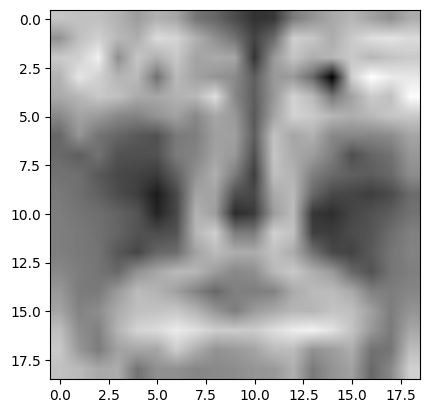

In [24]:
from matplotlib import pyplot as plt
# each column of corpus is a 19x19 image
plt.imshow(corpus[:,3].reshape(19,19).T, cmap='gray',interpolation='bilinear')

In [26]:
W,H = nmf(corpus, 50,lr=0.01, epochs=10000, reg_lambda=0.01)

Epoch 0: loss = 11383.630638577955
Epoch 10: loss = 8087.486054180768
Epoch 20: loss = 5150.5187256569325
Epoch 30: loss = 2486.6395881000603
Epoch 40: loss = 598.5174602257408
Epoch 50: loss = 542.7635436187578
Epoch 60: loss = 522.6305164294092
Epoch 70: loss = 503.1078481254741
Epoch 80: loss = 484.1850770051982
Epoch 90: loss = 465.85384657579743
Epoch 100: loss = 448.1077498115589
Epoch 110: loss = 430.94232241409543
Epoch 120: loss = 414.3550164084462
Epoch 130: loss = 398.3451576824598
Epoch 140: loss = 382.91387186880524
Epoch 150: loss = 368.06397195985886
Epoch 160: loss = 353.7997938057768
Epoch 170: loss = 340.1269707851134
Epoch 180: loss = 327.05213294270345
Epoch 190: loss = 314.5825183391108
Epoch 200: loss = 302.7254993562093
Epoch 210: loss = 291.4880103456794
Epoch 220: loss = 280.87589323656505
Epoch 230: loss = 270.8931822258945
Epoch 240: loss = 261.5413514811045
Epoch 250: loss = 252.81857987072573
Epoch 260: loss = 244.71908509544886
Epoch 270: loss = 237.232589